TRAINIG MODEL WITH DATA AUGMENTATION

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
np.set_printoptions(precision=3)
from imageio import imread
from skimage.transform import resize
import cv2
from cv2 import IMREAD_GRAYSCALE,COLOR_BGR2GRAY
from google.colab.patches import cv2_imshow
import os
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.transform import resize
from keras.optimizers import Adam,SGD,RMSprop,Adadelta
from keras.callbacks import ReduceLROnPlateau ,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
from tensorflow.keras.utils import img_to_array

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


veriseti 3 e ayırma

In [3]:
path= "/content/drive/MyDrive/Colab Notebooks/data"

In [4]:
%%time

X_data = []
y_data = []
for subdir, dirs, files in os.walk(path):
   print(subdir)
   for file in files:
        pic = cv2.imread(os.path.join(subdir, file))
        pic = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)
        pic = cv2.resize(pic, (96, 96))
        
        X_data.append(pic)
        y_data.append(int(subdir[-1]))



X = np.array(X_data) / 255
y = np.array(y_data)

print(X.shape)
print(y.shape)

/content/drive/MyDrive/Colab Notebooks/data
/content/drive/MyDrive/Colab Notebooks/data/0
/content/drive/MyDrive/Colab Notebooks/data/1
(3000, 96, 96)
(3000,)
CPU times: user 7.65 s, sys: 1.23 s, total: 8.87 s
Wall time: 1min 6s


In [7]:
pip install split-folders[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:

#### Import the package
import splitfolders
###### Path of input folder
input_folder = '/content/drive/MyDrive/Colab Notebooks/data'
#######ration of split is 60%, 20% and 20%
splitfolders.ratio(input_folder, output="dataset", 
                   seed=42, ratio=(.6, .2, .2), 
                   group_prefix=None)


Copying files: 3000 files [00:07, 381.99 files/s]


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle =True)
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.20)


print(f"X_train: {len(X_train)}")
print(f"y_train: {len(y_train)}")

print(f"X_train shape: {X_train.shape}")

print(f"X_val: {len(X_val)}")
print(f"y_val: {len(y_val)}")

print(f"X_test: {len(X_test)}")
print(f"y_test: {len(y_test)}")

X_train: 1920
y_train: 1920
X_train shape: (1920, 96, 96)
X_val: 480
y_val: 480
X_test: 600
y_test: 600


In [10]:
img = io.imread('/content/drive/MyDrive/Colab Notebooks/data/1/y0.jpg')
x = img.reshape((1, ) + img.shape)

In [11]:
datagen = ImageDataGenerator(   
        brightness_range = [1.0,0.6],
        horizontal_flip=True,
        fill_mode='constant') 

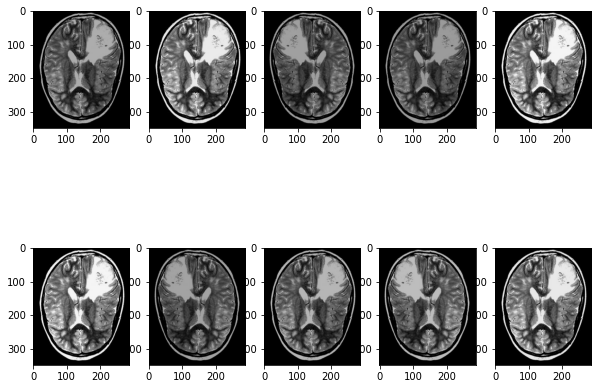

In [12]:
it = datagen.flow(x, batch_size=16)


fig = plt.figure(figsize=(10,8))
for i in range(10):
    plt.subplot(2,5,(i+1) )
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)
plt.show()

In [13]:
i = 0
for batch in datagen.flow(x, batch_size=16,  
                          save_to_dir='/content/drive/MyDrive/Colab Notebooks/augmented',
                          save_format='jpg'):
    i += 1
    if i > 5:
        break  # otherwise the generator would loop indefinitely  



In [14]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        brightness_range = [0.6,1.0],
        horizontal_flip=True,
        fill_mode='constant') 

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(
        '/content/dataset/train', 
        target_size=(96, 96), 
        batch_size=64,
        class_mode='sparse',
        color_mode='rgb', 
        shuffle=True) 

validation_generator = validation_datagen.flow_from_directory(
        '/content/dataset/val',
        target_size=(96, 96),
        batch_size=64,
        class_mode='sparse',
        shuffle=True)

test_generator = test_datagen.flow_from_directory(
        '/content/dataset/test',
        target_size=(96, 96),
        batch_size=64,
        class_mode='sparse')

Found 1800 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [16]:
class_dictionary = train_generator.class_indices
#---create a dictionary of labels---
class_dictionary = { value:key for key,value in
    class_dictionary.items()}
#---convert the dictionary to a list---
class_list = [value for _,value in class_dictionary.items()]
print(class_list)

['0', '1']


In [17]:
model = tf.keras.Sequential()
for i in range(4):
   model.add(tf.keras.layers.Conv2D(
                                 filters =32,
                                 kernel_size=5,
                                 strides=(1,1),
                                 padding="same",
                                 activation= "tanh",
                                 input_shape=(96, 96, 3)))
   model.add(tf.keras.layers.MaxPooling2D((2,2)))


model.add(tf.keras.layers.Flatten())


model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3))
    


  
# Add the output layer
model.add(tf.keras.layers.Dense(2, activation="sigmoid"))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
 


In [24]:
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30,verbose=1,min_delta = 1e-5,mode="max",restore_best_weights=True)
callback2=  ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=20, min_lr=1e-4)
callback = [callback1,callback2]

model.fit_generator(
        train_generator,
        steps_per_epoch= 1800 // 64,  
        epochs=300,
        validation_data = validation_generator,
        callbacks=callback)

<ipython-input-24-4521ebb72ee9>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(


Epoch 1/300
28/28 [==============================] - 9s 307ms/step - loss: 0.1748 - accuracy: 0.9291 - val_loss: 0.1554 - val_accuracy: 0.9333 - lr: 0.0010
Epoch 2/300
28/28 [==============================] - 8s 275ms/step - loss: 0.1067 - accuracy: 0.9666 - val_loss: 0.0576 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 3/300
28/28 [==============================] - 8s 294ms/step - loss: 0.0604 - accuracy: 0.9804 - val_loss: 0.0319 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 4/300
28/28 [==============================] - 10s 380ms/step - loss: 0.0440 - accuracy: 0.9902 - val_loss: 0.0411 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 5/300
28/28 [==============================] - 7s 233ms/step - loss: 0.0327 - accuracy: 0.9919 - val_loss: 0.0374 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 6/300
28/28 [==============================] - 8s 292ms/step - loss: 0.0192 - accuracy: 0.9954 - val_loss: 0.0502 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 7/300
28/28 [==============================] - 7s 241ms/s

In [25]:
import time
t0 = time.time()
degerlendirme = model.evaluate(test_generator)
t1 = time.time()
elapsed = (t1-t0)/600
print(f"loss değeri :  {np.array([degerlendirme[0]])}")
print(f"accuracy değeri : {np.array([degerlendirme[1]])}\n")

print("bir gözlemin test edilmesi: " + time.strftime("%H:%M:%S:{}".format(str(elapsed % 1)[15:])[:11], time.gmtime(elapsed))+ " milisaniye")

10/10 [==============================] - 1s 133ms/step - loss: 0.0747 - accuracy: 0.9783
loss değeri :  [0.075]
accuracy değeri : [0.978]

bir gözlemin test edilmesi: 00:00:00:27 milisaniye
